<a href="https://colab.research.google.com/github/guillermohenrion/Social-Network-Analytics/blob/master/nps_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install twython
#!pip install ftfy
#!pip install pyLDAvis
#!python -m spacy download es_core_news_sm


In [2]:
from twython import Twython
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from PIL import Image
from os import path
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import ftfy
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import os
from gensim.models.wrappers import LdaMallet, ldamallet
from gensim.corpora import Dictionary
import spacy
import pyLDAvis.gensim
import csv
from unicodedata import normalize
import string

SEED = 8888
#from wordcloud import WordCloud, STOPWORDS
from spacy.lang.en.stop_words import STOP_WORDS

twitter = Twython("U63VxPMqLMwTPFUWEcPUeWMng", "sbz3lDj50wMdteqmDCXIexM7wuCxapGs89GtOlSDZV5C1W1hQz",
                    "280807268-MgZfUIUEb1vkPehfjB8sfuicMstiw0Afek49kkNL", "g8QammrsFv1zHfWrGtypSkNloEx1tmU2IpzRaW6JJNjIX")


twitter2= Twython("1MBA20oxA5BiYqRaSjMN3oqYe","faLpEuitVadZAKZMYqtJwdMVrpLlZkLhtNOW94YsGsAfXwcadn",
"280807268-mVB5Lz2MTRC7rUTNoIa3HF34LFyE6qGNQAkUPLVM","paviGM8YU6t0cTQlMUS8j1dysgcva1drWSA8J3tJJ2w2G")

twitter.sleep_on_rate_limit = True
#nltk.download('stopwords')

In [3]:
def sacarURL(t):
    p=re.compile('<a [^>]*>')
    p2=re.compile('</a>')
    r=re.sub(p, '', t)
    r=re.sub(p, '', t)
    r=re.sub(p, '', t)
    r=re.sub(p2, '', r)
    r=re.sub(p2, '', r)
    r=re.sub(p2, '', r)
    return r


In [4]:
######################################################################################################################
# Funciones
######################################################################################################################

def cleaner(text,stopwords, is_topic=False):
    if not is_topic:
        text = text.lower()  # texto a minúsculas
        text = re.sub(r'\[.*?¿\]%', ' ', text)  # Se remueven corchetes
        text = re.sub(r'\(.*?¿\)%', ' ', text)  # Se remueven parentesis
        text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # Se remueven signos de puntuación
        text = re.sub(r'\w*\d\w*', '', text)  # Se remueven palabras que contienen dígitos.
        text = re.sub(r'\n', ' ', text)  # Sustituye nueva línea por un espacio
        text = re.sub(r'\s+', ' ', text, flags=re.I)  # Sustituye los múltiples espacios por sólo un espacio
        text = re.sub(r'[‘’“”…«»°*_/¿¡!?]', '', text)  # Remueve otros caracteres no sintácticos
        text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+|\u20AC", r"\1",
                      normalize("NFD", text), 0, re.I)  # NFD y eliminar diacríticos y símbolo euro
        text = normalize('NFC', text)  # NFC
        text_list = []
        for w1 in text.split(' '):
            text_list.append(w1)
        text_non_stop = [word for word in text_list if word not in stopwords]
        return text_non_stop
    else:
        text_non_stop = [word for word in text if word not in stopwords]
        bigram_list = bigram[text_non_stop]
        out_text = lemmatization(' '.join(bigram_list), allowed_postags=['NOUN'])  # , 'ADJ', 'PROPN'
        return out_text


def lemmatization(texts, allowed_postags=None):
    if allowed_postags is None:
        allowed_postags = ['NOUN']
    texts_out = [token.lemma_ for token in nlp(texts) if token.pos_ in
                 allowed_postags and token.text not in black_list and len(token.text) > 2]
    return texts_out


def display_topics(model, model_type='lda'):
    for topic_idx, topic in enumerate(model.print_topics()):
        print('Topic %d:' % topic_idx)
        if model_type == 'hdp':
            print(" ".join(re.findall(r'\*(.[^\*-S]+).?', topic[1])), '\n')
        else:
            print(" ".join(re.findall(r'\"(.[^"]+).?', topic[1])), '\n')


def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit

    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
            lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        elif model == 'mallet':
            lm = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
            lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())

    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel('num_topics')
    plt.ylabel('Coherence score')
    plt.legend('c_v', loc='best')
    plt.show()

    return lm_list, c_v


def format_topics_sentences(ldamodel=0, corpus=[], texts=0):
    sent_topics_df = pd.DataFrame()  # - n

    # Tema principal en cada documento
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Tema dominante, porcentaje de contribución y palabras claves
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Tema dominante
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Agrega el texto original al final
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


######################################################################################################################
# Carga de archivos
######################################################################################################################

In [5]:
black_list = ['twitter_com', 'suffix_twitter', 'n', 'q', 'eh', 'me', 'xq', 'z', 'x', 'etc', 'd', 'm', 's', 'u', 'p', 'l', 'as', 'av', 'j', 'porq', 'c',
              'v', 'cdo', 'i', 'unas', 'k', 't', 'pq', 'b', 'g', 'ne', 'r', 'h', 'qu', 'f', 'co', 'ud', 'sta', 'srta',
              'sr', 'sra', 'srita', 'tb', 'osea', 'po', 'ala', 'ami', 'ka', 'mo', 'migo', 'lis', 'in', 'idas', 'asique',
              'aunq', 'miy', 'lla', 'unlam', 'na', 'don', 'xxxx', 'yla', 'qie', 'qur', 'qye', 'fu', 'my', 'ke', 'laa',
              'll', 'mm', 'tmb', 'pr', 'ay', 'or', 'nc', 'xk', 'xx', 'ye', 'rn', 'hr', 'eramos', 'estabamos', 'estais',
              'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos',
              'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos',
              'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras',
              'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos',
              'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis',
              'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras',
              'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais',
              'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvieramos', 'tuviesemos', 'vez']

In [6]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords.extend(black_list )

nlp = spacy.load('es_core_news_sm')


In [7]:
user_tweets = twitter.get_user_timeline(screen_name='alferdez',
                                        include_rts=True, count=200, tweet_mode="extended")
tweetdf=pd.DataFrame([], columns=['id', 'text'])
for tweet in user_tweets:
    tweet['text'] = Twython.html_for_tweet(tweet)
    new_row={'id':tweet['id'], 'text':sacarURL(tweet['text'])}
    tweetdf=tweetdf.append(new_row, ignore_index=True)

In [8]:
tweetdf['text_orig'] = tweetdf['text']  # Resguardamos original
tweetdf['text'] = tweetdf['text'].apply(cleaner, args=(stopwords, False,))


In [9]:
bigram = gensim.models.Phrases(tweetdf.text.to_list(), min_count=5, threshold=10.0)
tweetdf['text'] = tweetdf['text'].apply(cleaner, args=(stopwords,True,))

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [10]:
tweetdf

,id,text,text_orig
0,1273922263780331521,"[viernes, radiar, noto]",El Presidente (@alferdez) será entrevistado es...
1,1273921482201186307,[],No te lo pierdas... @alferdez en @NacionalAM87...
2,1273818521731022851,"[gol, alferdez]","Una vez Alberto (cuando era Alberto, y no el P..."
3,1273816494242136064,"[culpar, alferdez]","Ah, mirá! \nEn Brasil es ""por la pandemia"", ac..."
4,1273812144136638465,"[empresa, programar, pagar, partir, salario, m...",Es importante aclarar que LATAM fue una de las...
...,...,...,...
195,1264371056594354181,"[salud, virus]","🇦🇷 @alferdez: ""Angustiante es enfermarse, no s..."
196,1264370191447842817,[interesar],“Que no nos ganen los ansiosos o los que tiene...
197,1264334635414228992,[],EN VIVO | Conferencia de prensa del presidente...
198,1264272708352778243,"[reunión, videoconferencia, alcanzar, aislamie...",Este mediodía mantuve reuniones por videoconfe...


In [11]:
# Corpus y diccionario para gensim
dictionary = Dictionary(tweetdf['text'].to_list())
dictionary.compactify()
# Filtrado de extremos
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in tweetdf['text'].to_list()]

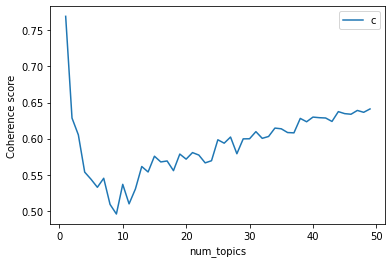

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Topic 0:
gobernador virus compromiso presidente trabajar desarrollar futuro empresa salud alferdez 

Topic 1:
empresa gracia año compromiso historia capitalismo ideo visitar comercio junio 

Topic 2:
salud alferdez ciudad gente medir trabajar lugar virus soberania aislamiento 

Topic 3:
gracia casar provincia caso cuidarteescuidarnos personar viernes interesar entrevistar pais 

Topic 4:
aguar virus mujer problema dia riesgo salud presidente periodista vida 



In [12]:
lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=tweetdf['text'].to_list(),
                                 limit=50, model='lsi')  # 10, 30?


ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)
display_topics(ldamodel)

In [13]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
display_topics(lsimodel)

Topic 0:
virus empresa salud gracia caso ciudad provincia gente casar trabajar 

Topic 1:
empresa virus ciudad gracia trabajar telefenoticias capitalismo provincia compromiso barrio 

Topic 2:
gracia salud virus ciudad empresa coser gente vida caso junio 

Topic 3:
provincia casar caso empresa salud gracia cantidad ciudad virus semana 

Topic 4:
gracia salud empresa gente vida caso riesgo coser distanciar provincia 

Topic 5:
trabajador partir transportar contagio empresa lugar modo medir crecimiento salud 

Topic 6:
año mujer historia sociedad caminar desigualdad dia partir violencia pie 

Topic 7:
compromiso caso casar empresa provincia trabajar medir tiempo gobernador gente 

Topic 8:
trabajar junio compromiso gente año trabajador coser partir medir casar 

Topic 9:
alferdez compromiso trabajar ciudad caminar oportunidad poder pais virus gobernador 



In [14]:

tweetdf['text'][0]

['viernes', 'radiar', 'noto']

In [15]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

text=''
tweetdf['text'][0].sort()
for word in tweetdf['text']:
    wc=' '.join(word)
    text = text+' '+wc;
    
text

' noto radiar viernes  gol alferdez culpar alferdez empresa programar pagar partir salario mayar abril trabajador emplear respuesta peligrar pasar destino unirnos futuro democracia justicia democracia coincidencia bandera defensa medir cantidad gente lugar motivar crecimiento caso tiempo estricto responsable crecimiento contagio partir viernes transportar personar rubro anunciar transportar trabajador medir autoridad problema diferenciar salud coser vida adjetivar adjetivar adjetivar expropiación frenar alferdez_telefenoticias comercio comercio consecuencia albertoentlfnoticias presidente presidente olvidar despues tiempo problema diferenciar ciudad lugar problema salir pais obligación telefenoticias futuro empresa telefenoticias empresa empresa concursar seriar maniobrar dañar telefenoticias formar esforzar acordar acreedor compromiso habitante salud momento vida riesgo telefenoticias despues gente trabajar negocio emplear telefenoticias industriar protocolar actividad comercio estric

In [16]:
wordcloud = WordCloud().generate(text)

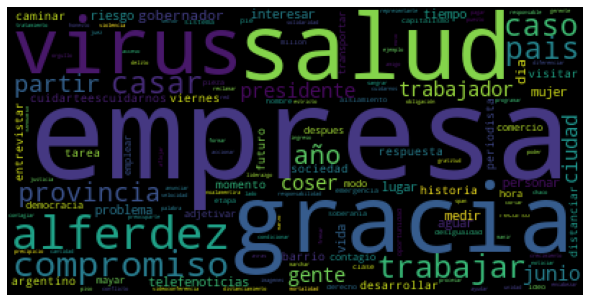

In [17]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

